In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import six

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline


folder = 'figures'

import flotilla

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'
study = flotilla.embark('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)
not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

psi = study.splicing.singles.ix[not_outliers]
grouped = psi.groupby(study.sample_id_to_phenotype)
psi_filtered = grouped.apply(lambda x: x.dropna(axis=1, thresh=20))


/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:810: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/__init__.py:55: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


2016-05-15 19:16:31	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json
2016-05-15 19:16:31	Parsing datapackage to create a Study object
2016-05-15 19:17:03	Initializing Study
2016-05-15 19:17:03	Initializing Predictor configuration manager for Study
2016-05-15 19:17:03	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-05-15 19:17:03	Added ExtraTreesClassifier to default predictors
2016-05-15 19:17:03	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-05-15 19:17:03	Added ExtraTreesRegressor to default predictors
2016-05-15 19:17:03	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-05-15 19:17:03	Added GradientBoostingClassifier to default predictors
2016-05-15 19:17:03	Predictor GradientBoostingRegressor is of type <class 'sklearn.

### Enrichment of this modality, within phenotype

i.e. *"What GO categories are iPSC bimodal events enriched for, compared to other modalities in iPSC?"*

In [2]:
figure_folder = '{}/gene_ontology'.format(folder)
! mkdir $figure_folder

In [3]:
study.splicing.feature_expression_id_col = 'ensembl_id'

In [4]:
np.finfo(np.float128).eps

1.084202172485504434e-19

MN
	bimodal
	excluded
	included
	uncategorized
... empty GO enrichment!
NPC
	bimodal
	excluded
	included
	uncategorized
... empty GO enrichment!
iPSC
	bimodal
	excluded
	included
	middle
... empty GO enrichment!
	uncategorized


/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/data_model/gene_ontology.py:161: UserWarning: No GO categories enriched in provided features
  warnings.warn('No GO categories enriched in provided features')


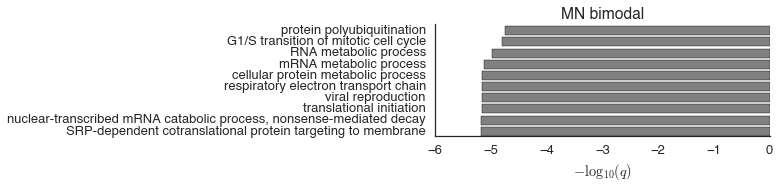

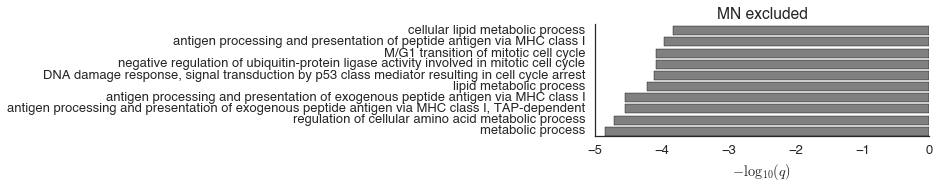

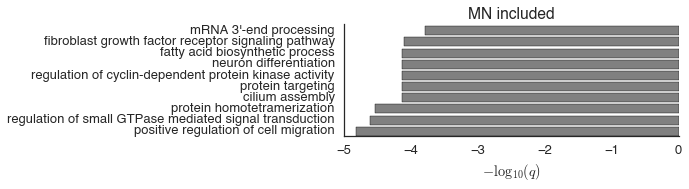

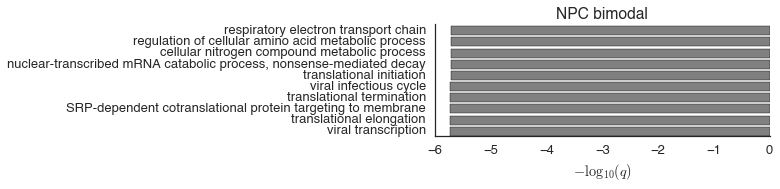

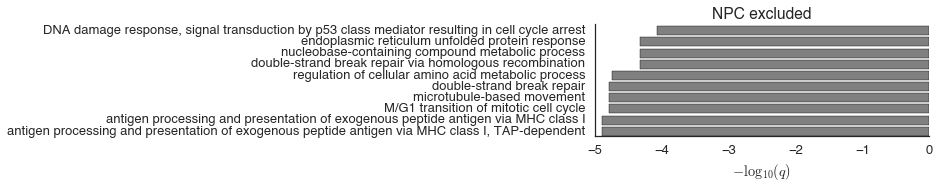

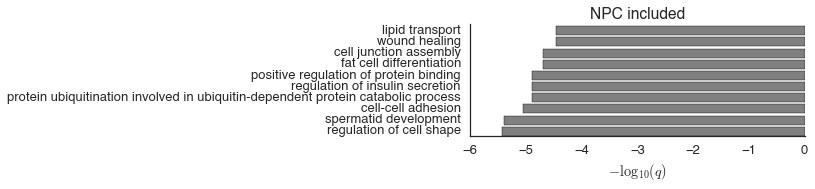

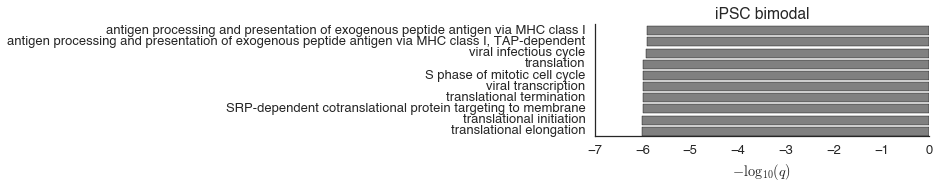

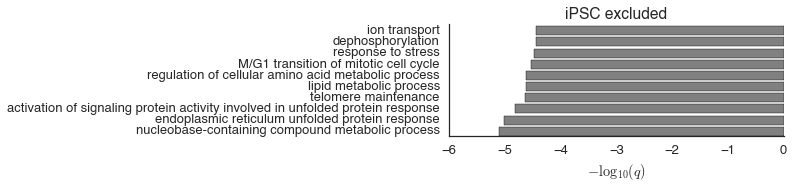

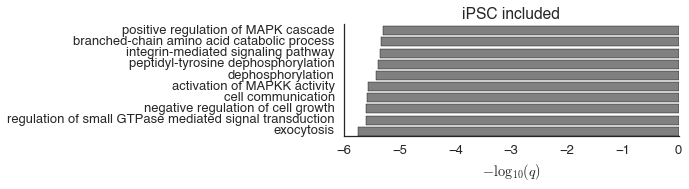

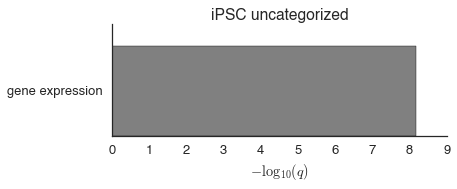

In [8]:
from flotilla.visualize.gene_ontology import plot_go_enrichment
gos = []
for (phenotype), phenotype_df in study.supplemental.modalities_tidy.groupby(['phenotype']):
    print phenotype
    background = study.splicing.splicing_to_expression_id(phenotype_df.event_id)
    for modality, modality_df in phenotype_df.groupby('modality'):
        print '\t', modality
        modality_genes = study.splicing.splicing_to_expression_id(modality_df.event_id)
        go = study.go_enrichment(modality_genes, background, #p_value_cutoff=0.01, 
                                 min_feature_size=5, min_background_size=10,
                                 domain='biological_process')
        if go is None or go.empty:
            print '... empty GO enrichment!'
            continue
        fig, ax = plt.subplots(figsize=(6, 2))
        ax = plot_go_enrichment(data=go, color='grey')
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
#         fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_within_celltype_{}_{}.pdf'.format(figure_folder, modality, phenotype))

### Enrichment of this modality, across phenotypes

i.e. *"What GO categories are iPSC bimodal events enriched for, compared to bimodal events in NPC and MN?"*

In [ ]:
import itertools

modalities_all_celltypes = study.supplemental.modalities_tidy.groupby('event_name').filter(
    lambda x: len(x)==len(study.phenotype_order))

go_dfs = []

for (phenotype), phenotype_df in modalities_all_celltypes.groupby(['modality']):
    print phenotype
    background = study.splicing.splicing_to_expression_id(phenotype_df.event_name)
    for modality, modality_df in phenotype_df.groupby('phenotype'):
        print '\t', modality
        modality_genes = study.splicing.splicing_to_expression_id(modality_df.event_name)
        go = study.go_enrichment(modality_genes, background, p_value_cutoff=0.01, 
#                                  min_feature_size=5, min_background_size=10,
                                domain='biological_process')
        if go is None or go.empty:
            print '\t... empty GO enrichment!'
            continue
            
        go['modality'] = modality
        go['phenotype'] = phenotype
        go_dfs.append(go.reset_index())
        fig, ax = plt.subplots(figsize=(4, 2))
        ax = plot_go_enrichment(data=go, color='grey')
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
#         fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_across_celltypes_{}_{}.pdf'.format(figure_folder, modality, phenotype))
go_df = pd.concat(go_dfs, ignore_index=True)

### Enrichment of this modality vs all other modalities across phenotypes

i.e. *"What GO categories are bimodal events in iPSC, NPC and MN enriched for, over other modalities in those celltypes?"*

In [ ]:
modalities_all_celltypes = study.supplemental.modalities_tidy.groupby('event_name').filter(
    lambda x: len(x) == len(study.phenotype_order))

In [ ]:
import itertools

background = study.splicing.splicing_to_expression_id(modalities_all_celltypes.event_name)


for (group), df1 in modalities_all_celltypes.groupby(['modality']):
    print group
    foreground = study.splicing.splicing_to_expression_id(df1.event_name)
    go = study.go_enrichment(foreground, background, p_value_cutoff=0.1, 
#                              min_feature_size=5, min_background_size=10,
                             domain='biological_process')
    if go is None or go.empty:
        print '\t... empty GO enrichment!'
        continue

    fig, ax = plt.subplots(figsize=(4, 2))
    ax = plot_go_enrichment(data=go, color='grey')
    ax.set_title(group)
    fig = plt.gcf()
    fig.tight_layout()
    fig.savefig('{}/modality_go_enrichment_across_celltypes_{}.pdf'.format(figure_folder, group))